In [1]:
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nbformat

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten,Dropout,Conv2D
from keras.layers import LSTM
from keras.layers import Reshape
from keras.layers import Dense, Dropout, LSTM, Embedding, Activation, Lambda, Bidirectional
from tensorflow.keras.layers import TimeDistributed
from sklearn.model_selection import train_test_split
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

2023-08-04 20:15:16.635614: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-04 20:15:16.654775: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        print("GPU device:", gpu)
        print("number of GPU device: ",len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("No GPU devices found.")


tf.config.experimental.set_memory_growth(gpus[0], True)

GPU device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
number of GPU device:  1


In [4]:
from kerastuner import HyperModel, RandomSearch

/tmp/ipykernel_747072/3805274735.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


In [5]:
%run 'lstminput.ipynb'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/tmp/ipykernel_747072/3505619144.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)
/tmp/ipykernel_747072/2970507474.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(seq, np.int8)
/tmp/ipykernel_747072/3818073805.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


In [6]:
train_x_tensor.shape

(8000, 450, 5)

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, TimeDistributed, Dense
from kerastuner.tuners import RandomSearch
import kerastuner

In [28]:
class MyHyperModel(kerastuner.HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        sequence_length = 450
        one_hot_length = 5
        input_shape = (sequence_length, one_hot_length)
    
        model = keras.Sequential()
        model.add(Conv1D(filters=hp.Int('filters', min_value=8, max_value=64, step=8), kernel_size=hp.Int('kernel_size', min_value=1, max_value=6, step=1), padding='same', activation='relu', input_shape=input_shape))
        if hp.Boolean("dropout"):
            model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Conv1D(filters=hp.Int('filters', min_value=8, max_value=64, step=8), kernel_size=hp.Int('kernel_size', min_value=1, max_value=6, step=1), padding='same', activation='relu'))
        model.add(MaxPooling1D(pool_size=1))
        model.add(TimeDistributed(Flatten())) 
        model.add(Bidirectional(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=512, step=32), return_sequences=True),input_shape=(450,5)))
        if hp.Boolean("dropout"):
            model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Bidirectional(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=512, step=32), return_sequences=True)))
        model.add(TimeDistributed(Dense(self.num_classes, activation='softmax')))
        if hp.Boolean("dropout"):
            model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Dense(self.num_classes, activation='softmax'))
        model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model



In [29]:
hypermodel = MyHyperModel(num_classes=5)

In [45]:
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=100,
    executions_per_trial=2,
    directory='random_search',
    project_name='hybrid_shm')



INFO:tensorflow:Reloading Tuner from random_search/hybrid_shm/tuner0.json


In [46]:
tuner.search_space_summary()



Search space summary
Default search space size: 6
filters (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': 'linear'}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [47]:
from tensorflow.keras.callbacks import EarlyStopping

In [48]:
log_dir = "logs/hybrid_hyper/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tf_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5)
tuner.search(train_x_tensor, train_y_tensor, epochs=150, validation_data=(test_x_tensor, test_y_tensor), batch_size=64, callbacks=[tf_callback, early_stopping_callback])



Trial 100 Complete [00h 03m 09s]
val_accuracy: 0.7979288995265961

Best val_accuracy So Far: 0.9804733395576477
Total elapsed time: 02h 47m 01s
INFO:tensorflow:Oracle triggered exit


In [49]:
tuner.get_best_hyperparameters()

In [50]:
tuner.results_summary()

Results summary
Results in random_search/hybrid_shm
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 29 summary
Hyperparameters:
filters: 64
kernel_size: 5
dropout: False
lstm_units: 384
learning_rate: 0.001
dropout_rate: 0.2
Score: 0.9804733395576477

Trial 21 summary
Hyperparameters:
filters: 56
kernel_size: 2
dropout: False
lstm_units: 64
learning_rate: 0.001
Score: 0.9793089032173157

Trial 095 summary
Hyperparameters:
filters: 64
kernel_size: 5
dropout: False
lstm_units: 32
learning_rate: 0.001
dropout_rate: 0.2
Score: 0.9711755514144897

Trial 42 summary
Hyperparameters:
filters: 56
kernel_size: 5
dropout: True
lstm_units: 160
learning_rate: 0.01
dropout_rate: 0.4
Score: 0.9693005681037903

Trial 06 summary
Hyperparameters:
filters: 56
kernel_size: 5
dropout: False
lstm_units: 224
learning_rate: 0.001
Score: 0.9649477899074554

Trial 084 summary
Hyperparameters:
filters: 16
kernel_size: 4
dropout: True
lstm_units: 32
learning_rate: 0.01
dropout_rate: 

In [51]:
best_model = tuner.get_best_models(num_models=1)[0]

2023-08-05 20:53:50.770891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-05 20:53:50.771907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-05 20:53:50.772422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [52]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

2023-08-05 20:53:53.411982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-05 20:53:53.412678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-05 20:53:53.413221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - 2s 29ms/step


([<matplotlib.axis.YTick at 0x7ef9f033ea10>,
 [Text(0, 0.5, 'V'),
  Text(0, 1.5, 'D'),
  Text(0, 2.5, 'J'),
  Text(0, 3.5, 'N'),
  Text(0, 4.5, 'X')])

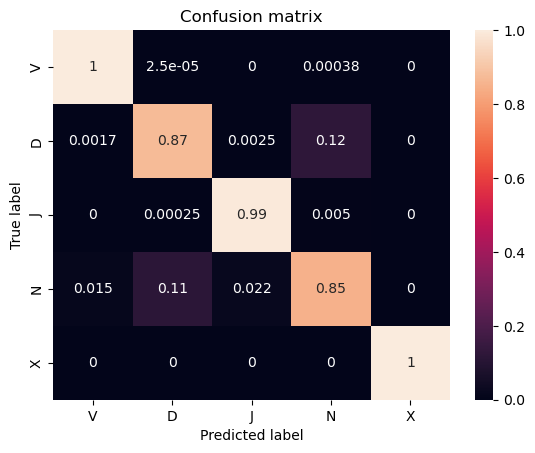

In [53]:
y_pred = best_model.predict(test_x_tensor)
pred_classes = np.argmax(y_pred, axis=-1)
y_true = np.argmax(test_y_tensor,axis=-1)
y_true_flat = y_true.flatten()
y_pred_flat = pred_classes.flatten()
cm = confusion_matrix(y_true_flat,y_pred_flat)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=['V', 'D', 'J', 'N','X'])
labels = ['V', 'D', 'J', 'N','X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

In [55]:
# accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print('Accuracy:', accuracy)

# precision
precision = precision_score(y_true_flat, y_pred_flat, average='macro')
print('Precision:', precision)

# recall
recall = recall_score(y_true_flat, y_pred_flat, average='macro')
print('Recall:', recall)

# F1-score
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
print('F1 Score:', f1)

Accuracy: 0.9907777777777778
Precision: 0.9450332555311943
Recall: 0.9434003954471771
F1 Score: 0.9441466806853829
